# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of an image classifier, from loading and inspecting the dataset to implementing and training a Convolutional Neural Network architecture. The sections guide you but you do not have to follow that specific order.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you using Colab notebook, save it as .ipynb and upload it. If you have your own machine with Jupyter installed, you can work there as well. Upload only the .ipynb file.


## Rules and Comments
- From the list of datasets and architectures listed in Canvas, each student was assigned **1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description.
- This is a DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course).
- **Deadline is October 17th 11:59 PM** (For late submission it is October 23rd 11:59PM)
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:**  
**Neptun ID:**
**Network:**
**Objects:**

## Task description

Your task is to compare the performance of a given pre-trained model and a modified version of it, using a given dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

Steps
1. If your dataset has more than 5 classes, then select 5 classes of your choice (explain why). If your dataset has 5 or less classes, ignore this step.
2. The dataset should be split into train, validation and test sets. Some datasets already have these splits, otherwise, you can split the training set into validation and test sets.
3. Use the test set to do inference with the pre-trained model. Calculate the accuracy of the pre-trained model.
4. Modify the pre-trained model and train it with the train/validation sets. Modifying means removing/replacing/adding layers. We recommend changing the: head (you need to do this because the pre-trained models were created to predict 1000 classes from Imagenet, however, in your case, the number of classes is different, so you must change the head); backbone (remove/replace layers in the backbone. Be aware that once you do that, you need to be able to adjust the networks output dimensions by changing the properties like filter size, padding, etc)
5. Use the test set to do inference with the newly modified/trained model. Calculate the accuracy.
6. Compare the results from the pre-trained model and the modified version.
7. Explain the differences.
Please submit only the notebook to Canvas. (Do not upload the dataset nor the models)

There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the accuracy, loss, and confusion matrix. Use Early stopping and save the best model while training your network.


# In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.


There are some example questions at the end of the notebook.

# NEPTUNE : X3FEMO | NAME : BAKHTAOUI AMINE | NETWORK : Resnet18| Object : Imagenette (320px version)

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
import requests
import tarfile
import io
import os
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

In [2]:
url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
response = requests.get(url)

if response.status_code == 200:
      tgz_bytes = io.BytesIO(response.content)
      with tarfile.open(fileobj=tgz_bytes , mode="r:gz") as tar :
               tar.extractall(path="dataset_folder")
      extracted_folder_path = os.path.abspath("dataset_folder")

      print("The Extracted folder path is ==> ", extracted_folder_path)
else :
       print("Failed To download the Dataset !!! ")

The Extracted folder path is ==>  /content/dataset_folder


In [3]:
import os
import shutil
import random

train_folder = os.path.join(extracted_folder_path, "imagenette2-320/train")
test_folder = os.path.join(extracted_folder_path , "imagenette2-320/test")

os.makedirs(test_folder , exist_ok=True)
classes = os.listdir(train_folder)

percentage_to_move = 0.2

for class_name in classes:
    class_path_train = os.path.join(train_folder, class_name)
    class_path_test = os.path.join(test_folder, class_name)

    os.makedirs(class_path_test, exist_ok=True)

    images = os.listdir(class_path_train)

    num_to_move = int(len(images) * percentage_to_move)

    images_to_move = random.sample(images, num_to_move)

    for image_name in images_to_move:
        src = os.path.join(class_path_train, image_name)
        dst = os.path.join(class_path_test, image_name)

        shutil.move(src, dst)

print("Images moved to the test set.")

Images moved to the test set.


#### Pre-processing the dataset (data loader with transformations)

#### Loading one example for each object type from the dataset
Show some images and labels of your dataset

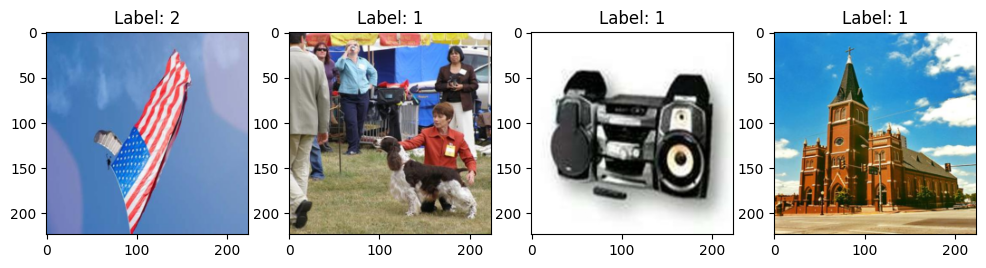

In [4]:
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a common size
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

# Load the dataset
imagenet_dataset = datasets.ImageFolder('/content/dataset_folder/imagenette2-320', transform=transform)

# Create a PyTorch DataLoader for easier data loading
dataloader = torch.utils.data.DataLoader(imagenet_dataset, batch_size=4, shuffle=True)

# Define a function to show images and the labels
def show_images_labels(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for i, ax in enumerate(axes):
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.set_title(f'Label: {labels[i]}')

    plt.show()

# Load a batch of images and labels
for batch in dataloader:
    images, labels = batch
    show_images_labels(images, labels)
    break


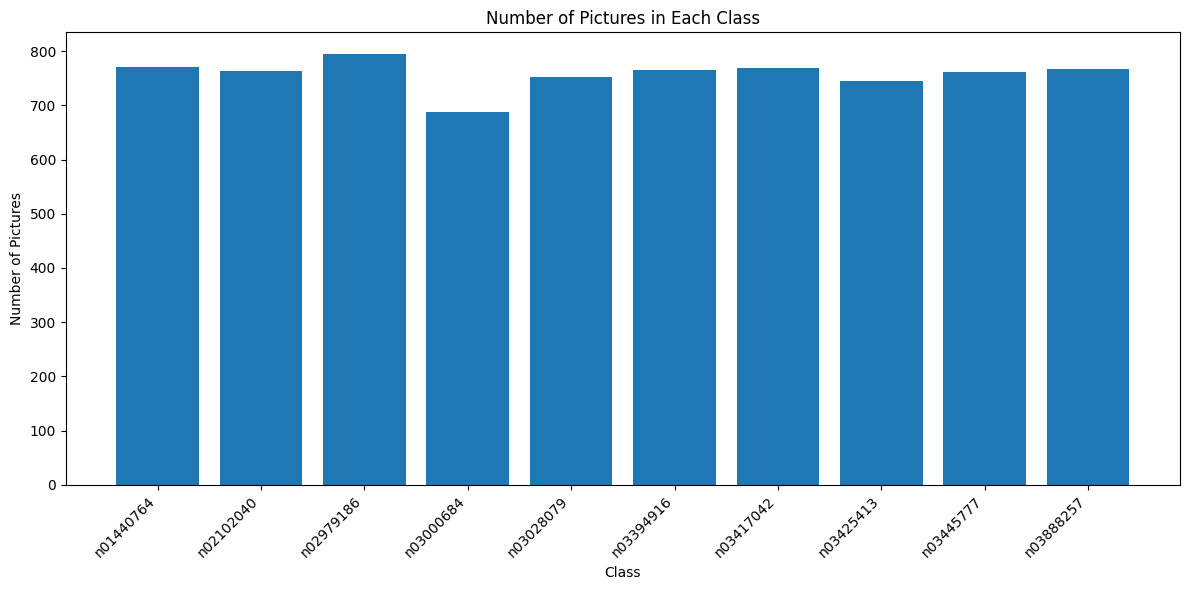

In [5]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset
imagenet_dataset = datasets.ImageFolder('/content/dataset_folder/imagenette2-320/train', transform=transform)

# Count the number of images in each class
class_counts = [0] * len(imagenet_dataset.classes)

for _, label in imagenet_dataset:
    class_counts[label] += 1

# Create a bar plot to show the number of pictures in each class
plt.figure(figsize=(12, 6))
plt.bar(range(len(imagenet_dataset.classes)), class_counts)
plt.xticks(range(len(imagenet_dataset.classes)), imagenet_dataset.classes, rotation=45, ha="right")
plt.xlabel('Class')
plt.ylabel('Number of Pictures')
plt.title('Number of Pictures in Each Class')
plt.tight_layout()
plt.show()


# Select the top 5 classes with the highest number of pictures .

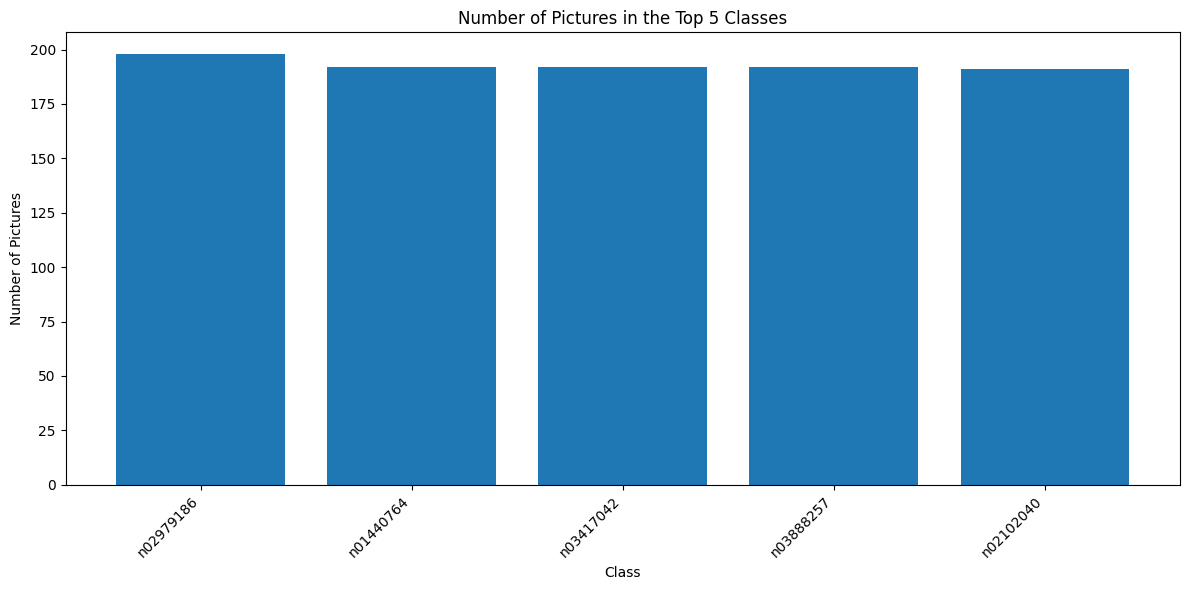

In [6]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset
imagenet_dataset = datasets.ImageFolder('/content/dataset_folder/imagenette2-320/test', transform=transform)

# Count the number of images in each class
class_counts = [0] * len(imagenet_dataset.classes)

for _, label in imagenet_dataset:
    class_counts[label] += 1

# Sort the classes by the number of images and select the top 5
top_classes_indices = sorted(range(len(class_counts)), key=lambda i: class_counts[i], reverse=True)[:5]

# Get the class names for the top 5 classes
top_classes = [imagenet_dataset.classes[i] for i in top_classes_indices]

# Create a bar plot to show the number of pictures in the top 5 classes
plt.figure(figsize=(12, 6))
plt.bar(range(5), [class_counts[i] for i in top_classes_indices])
plt.xticks(range(5), top_classes, rotation=45, ha="right")
plt.xlabel('Class')
plt.ylabel('Number of Pictures')
plt.title('Number of Pictures in the Top 5 Classes')
plt.tight_layout()
plt.show()

# Remove the other classes

In [7]:
import os

# Specify the path to the general folder
general_folder_path = '/content/dataset_folder/imagenette2-320'

# Define the top 5 classes
selected_class_names = ['n02979186', 'n01440764', 'n03417042', 'n03888257', 'n02102040']

# List the subfolders 'test,' 'validate,' and 'train'
subfolders = ['test', 'val', 'train']

# Iterate through the subfolders and delete class folders for classes you want to remove
for subfolder in subfolders:
    subfolder_path = os.path.join(general_folder_path, subfolder)

    # List class folders in the subfolder
    class_folders = os.listdir(subfolder_path)

    for class_folder in class_folders:
        if class_folder not in selected_class_names:
            # Delete the entire class folder and its contents
            class_path = os.path.join(subfolder_path, class_folder)
            shutil.rmtree(class_path)

# The subfolders now contain only the selected classes and deleted the other ones .


#### Splitting the dataset

In [8]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the path of the dataset
data_dir = '/content/dataset_folder/imagenette2-320'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create a dataset object
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a data loader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize lists to store X (images) and y (labels)
X = []
y = []

# Now we can iterate through the data loader to access batches of images and labels
for batch in dataloader:
    images, labels = batch
    X.extend(images)
    y.extend(labels)

#### Check the number of images and class balances in the  train, validation and test set

In [9]:
import os

general_folder_path = '/content/dataset_folder/imagenette2-320'

# List the subfolders 'train,' 'validate ('val'),' and 'test'
subfolders = ['train', 'val', 'test']

# Iterate through the subfolders to count the images and class balances
for subfolder in subfolders:
    subfolder_path = os.path.join(general_folder_path, subfolder)

    # List class folders in the subfolder
    class_folders = os.listdir(subfolder_path)

    # Initialize dictionaries to store counts for each class
    class_counts = {class_name: 0 for class_name in class_folders}

    # Iterate through the class folders and count images
    for class_folder in class_folders:
        class_path = os.path.join(subfolder_path, class_folder)

        # Count the number of images in the class folder
        class_count = len(os.listdir(class_path))
        class_counts[class_folder] = class_count

    # Display the counts and class balances for the subfolder
    total_images = sum(class_counts.values())
    print(f'{subfolder.capitalize()} Set:')
    print(f'Total Images: {total_images}')
    print('Class Balances:')
    for class_name, count in class_counts.items():
        class_balance = count / total_images
        print(f'Class: {class_name}, Count: {count}, Class Balance: {class_balance:.2%}')
    print()


Train Set:
Total Images: 3867
Class Balances:
Class: n02979186, Count: 795, Class Balance: 20.56%
Class: n03417042, Count: 769, Class Balance: 19.89%
Class: n03888257, Count: 768, Class Balance: 19.86%
Class: n01440764, Count: 771, Class Balance: 19.94%
Class: n02102040, Count: 764, Class Balance: 19.76%

Val Set:
Total Images: 1918
Class Balances:
Class: n02979186, Count: 357, Class Balance: 18.61%
Class: n03417042, Count: 389, Class Balance: 20.28%
Class: n03888257, Count: 390, Class Balance: 20.33%
Class: n01440764, Count: 387, Class Balance: 20.18%
Class: n02102040, Count: 395, Class Balance: 20.59%

Test Set:
Total Images: 965
Class Balances:
Class: n02979186, Count: 198, Class Balance: 20.52%
Class: n03417042, Count: 192, Class Balance: 19.90%
Class: n03888257, Count: 192, Class Balance: 19.90%
Class: n01440764, Count: 192, Class Balance: 19.90%
Class: n02102040, Count: 191, Class Balance: 19.79%



## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the given pre-trained model

In [10]:
import torch
import torchvision.models as models
# Load the pre-trained (the ResNet-18 model)
model = models.resnet18(pretrained=True)

# Set the model to evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Summary of the given pre-trained model

In [26]:
import torch
import torchvision.models as models
from torchsummary import summary

# Define the input tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device as the input tensor
model.to(device)

# Create a random input tensor of the appropriate size and move it to the same device
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Display the model summary
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Implement the new architecture with less parameter

In [12]:
import torch.nn as nn
model.fc=nn.Linear(model.fc.in_features,5)
model.eval()
model=model.to(device)

#### Summary of the new architecture

In [13]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 3. Training

#### Define your loss function

#### Define your optimizer

#### Train your network

#### Show the loss on training and validation sets

#### Show the accuracy on training and validation sets

Epoch 1/3: Train Loss: 0.2155, Train Accuracy: 95.66%
Validation Loss: 0.0467, Validation Accuracy: 99.06%
Epoch 2/3: Train Loss: 0.0501, Train Accuracy: 98.99%
Validation Loss: 0.0311, Validation Accuracy: 99.37%
Epoch 3/3: Train Loss: 0.0334, Train Accuracy: 99.35%
Validation Loss: 0.0249, Validation Accuracy: 99.32%
Final Test Loss: 0.0320, Test Accuracy: 98.96%


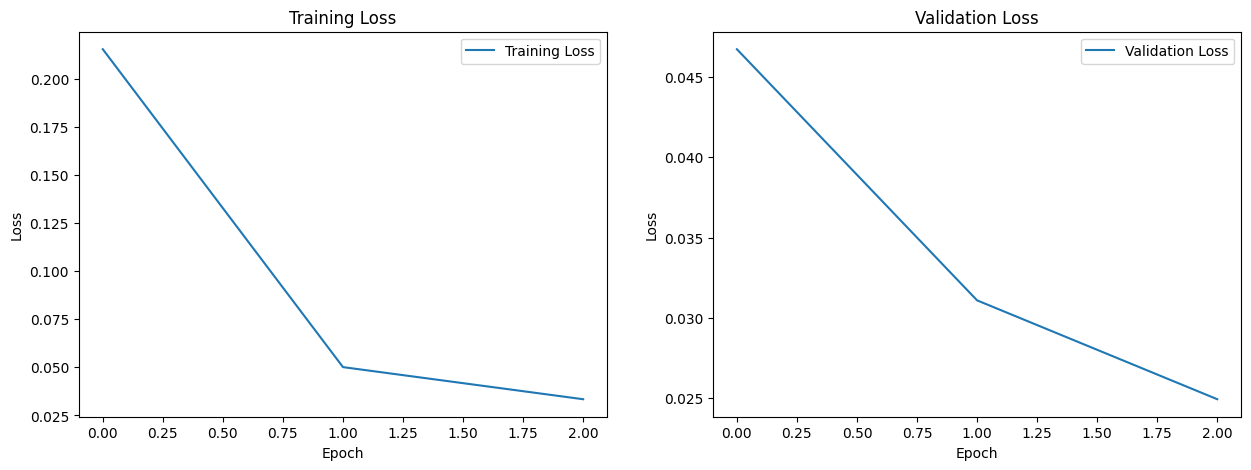

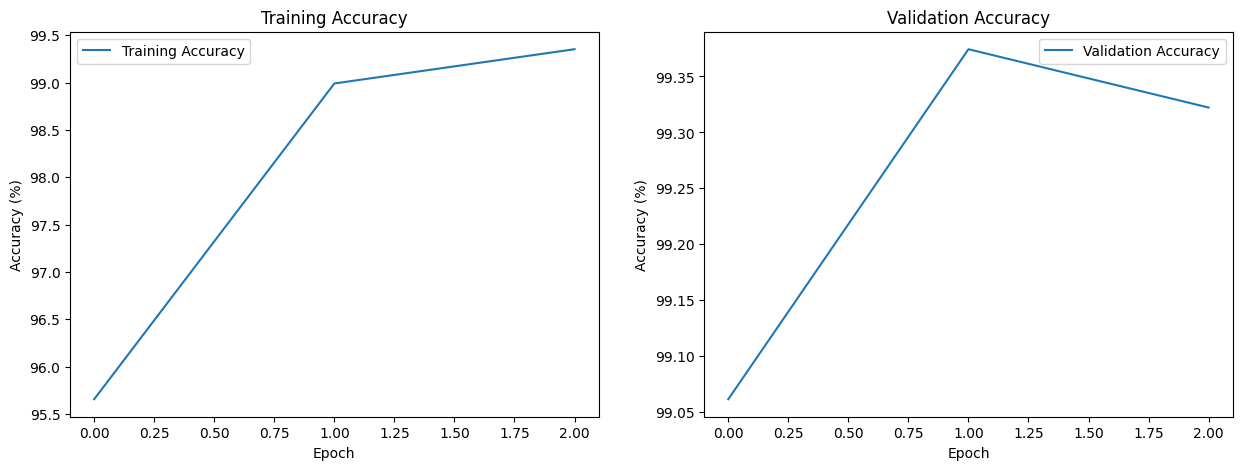

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define the batch size
batch_size = 32

# Load and preprocess Our dataset
dataset_path = '/content/dataset_folder/imagenette2-320'
train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(root=dataset_path + '/train', transform=transform), batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(datasets.ImageFolder(root=dataset_path + '/val', transform=transform), batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(datasets.ImageFolder(root=dataset_path + '/test', transform=transform), batch_size=batch_size)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set hyperparameters
num_epochs = 3

# Initialize lists to store loss and accuracy values
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation (evaluate on the validation set)
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = total_loss / len(validation_loader)
    val_accuracy = 100.0 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)

# Final evaluation on the test set (i use it here to see the accuracy and after i load the model and evaluate it again)
model.eval()
total_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss = total_loss / len(test_loader)
test_accuracy = 100.0 * correct / total
print(f'Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Separate plots for training and validation loss
plt.figure(figsize=(15, 5))

# Training loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

# Validation loss plot
plt.subplot(1, 2, 2)
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')

# Show the plots
plt.show()

# Separate plots for training and validation accuracy
plt.figure(figsize=(15, 5))

# Training accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training Accuracy')

# Validation accuracy plot
plt.subplot(1, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

# Show the plots
plt.show()


#### Save your trained CNN

In [17]:
torch.save(model.state_dict(),'model_dtd.pth')

## 4. Evaluation and Testing
Load your trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model

In [18]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

# Define the data transformations for the test set
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define the batch size
batch_size = 32

# Load and preprocess the test dataset
dataset_path = '/content/dataset_folder/imagenette2-320'
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Load the trained model
model.load_state_dict(torch.load('model_dtd.pth'))
model.eval()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize variables to track accuracy
correct = 0
total = 0

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Calculate and print the test accuracy
test_accuracy = 100.0 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 98.96%


#### Show the test accuracy next to the training and validation

Test Accuracy: 98.96% / Training Accuracy : 99.97% / Validation Accuracy : 99.32% / 


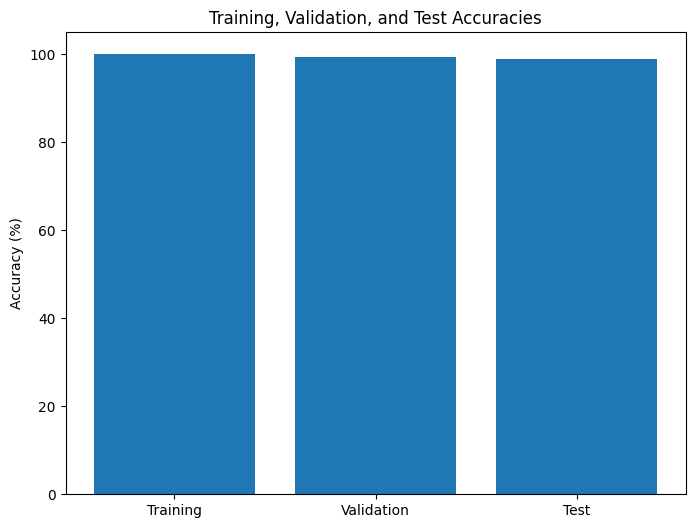

In [22]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the data transformations for the test set (also it should match the ones used for training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define the batch size
batch_size = 32

# Load and preprocess the test dataset
dataset_path = '/content/dataset_folder/imagenette2-320'
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Load the trained model
model.load_state_dict(torch.load('model_dtd.pth'))
model.eval()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize variables to track accuracy
correct = 0
total = 0

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Calculate and print the test accuracy
test_accuracy = 100.0 * correct / total


# Initialize variables to track accuracy
train_correct = 0
train_total = 0

# Evaluate the model on the training set
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

# Calculate the training accuracy
train_accuracy = 100.0 * train_correct / train_total

# Initialize variables to track accuracy
validation_correct = 0
validation_total = 0

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        validation_total += labels.size(0)
        validation_correct += predicted.eq(labels).sum().item()

# Calculate the validation accuracy
validation_accuracy = 100.0 * validation_correct / validation_total

#show the values of the training , validation and the test accuracies

print(f'Test Accuracy: {test_accuracy:.2f}% / Training Accuracy : {train_accuracy:.2f}% / Validation Accuracy : {validation_accuracy:.2f}% / ')

# Create a bar chart to show the training, validation, and test accuracies
accuracies = [train_accuracy, validation_accuracy, test_accuracy]


labels = ['Training', 'Validation', 'Test']

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies)
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracies')
plt.show()

#### Confusion matrix

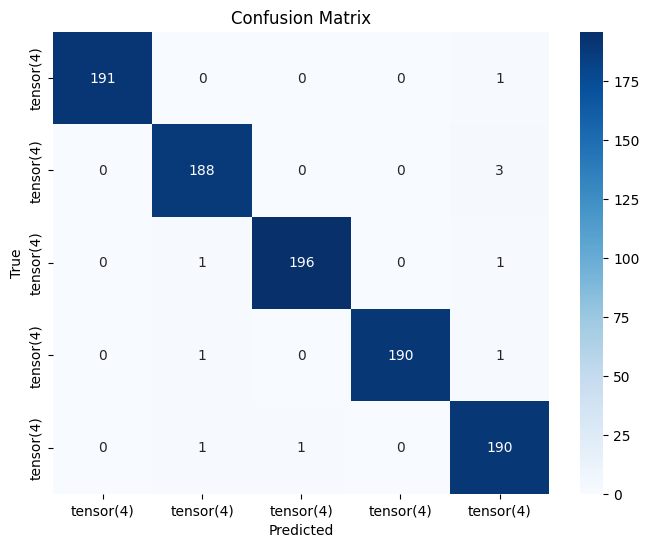

In [23]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure that the model is in evaluation mode
model.eval()

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set and collect labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Show some predictions

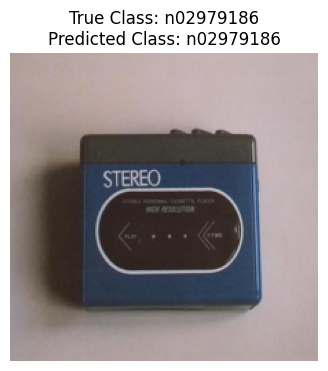

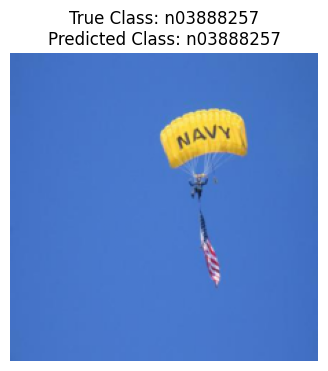

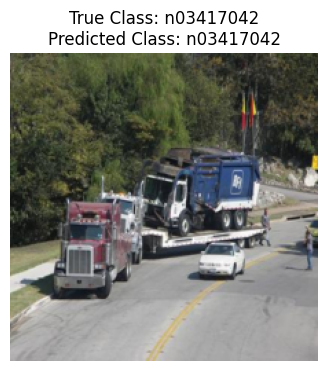

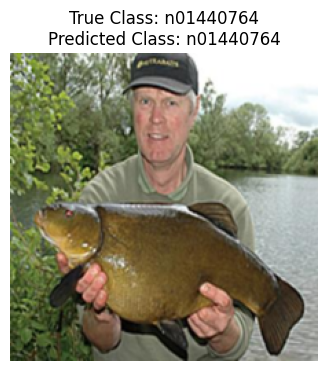

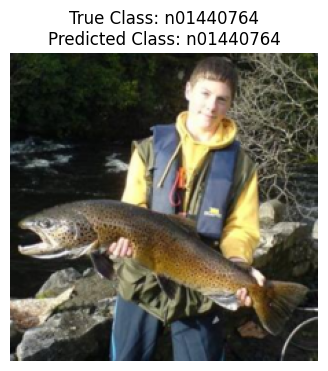

In [24]:
import random

# Set the model to evaluation mode
model.eval()

# Number of predictions to display
num_predictions = 5

# Randomly select images from the test set
random_indices = random.sample(range(len(test_dataset)), num_predictions)

# Display the selected images and their predictions
for idx in random_indices:
    input_image, true_label = test_dataset[idx]
    input_image = input_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)
        _, predicted_label = output.max(1)

    # Convert labels to class names
    true_class = test_dataset.classes[true_label]
    predicted_class = test_dataset.classes[predicted_label]

    # Display the image, true class, and predicted class
    plt.figure(figsize=(4, 4))
    plt.imshow(input_image.cpu().squeeze().permute(1, 2, 0))
    plt.title(f"True Class: {true_class}\nPredicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()


#### Missed predictions

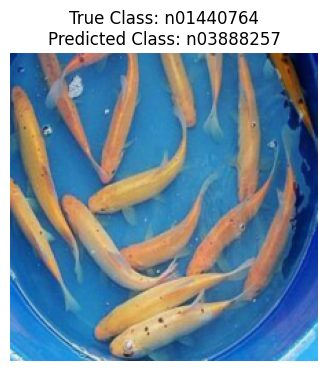

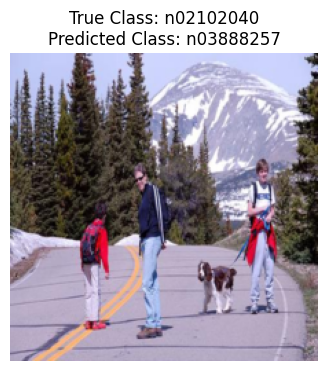

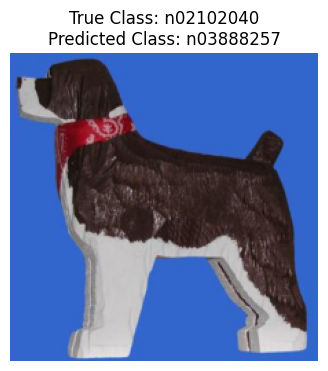

In [25]:
# Set the model to evaluation mode
model.eval()

# Number of missed predictions to display
num_missed_predictions = 3

# Create a list to store the indices of missed predictions
missed_indices = []

# Evaluate the model on the test set
with torch.no_grad():
    for idx, (input_image, true_label) in enumerate(test_dataset):
        input_image = input_image.unsqueeze(0).to(device)
        output = model(input_image)
        _, predicted_label = output.max(1)

        if predicted_label != true_label:
            missed_indices.append(idx)

        if len(missed_indices) == num_missed_predictions:
            break

# Display the images and their predicted labels for missed predictions
for idx in missed_indices:
    input_image, true_label = test_dataset[idx]
    input_image = input_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)
        _, predicted_label = output.max(1)

    # Convert labels to class names
    true_class = test_dataset.classes[true_label]
    predicted_class = test_dataset.classes[predicted_label]

    # Display the image, true class, and predicted class
    plt.figure(figsize=(4, 4))
    plt.imshow(input_image.cpu().squeeze().permute(1, 2, 0))
    plt.title(f"True Class: {true_class}\nPredicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()


#Edit the BackBone of the Resnet18 model and train the model with our train data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the data transformations for your dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define the batch size
batch_size = 32

# Load and preprocess your training dataset
train_dataset = datasets.ImageFolder(root='/content/dataset_folder/imagenette2-320/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes based on your problem
num_classes = 5

# Create an instance of the original model
original_model = models.resnet18(pretrained=True)

# Define the number of input features for the final classification layer
in_features = 512

# Create a custom model by removing specific layers and adding a custom classification layer
class CustomModel(nn.Module):
    def __init__(self, original_model, num_classes, in_features):
        super(CustomModel, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

# Create an instance of the custom model
custom_model = CustomModel(original_model, num_classes, in_features)
custom_model.to(device)

# Set hyperparameters
num_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_model.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(num_epochs):
    custom_model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = custom_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

# Plot the training accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training Accuracy')
plt.show()


Epoch 1/3: Train Loss: 0.2809, Train Accuracy: 92.11%
Epoch 2/3: Train Loss: 0.0481, Train Accuracy: 99.15%


## 5. Some example questions that help you prepare for the defense

* Data
    - Describe your dataset.
    - List augmentation techniques.
    - Normalization standardization why do we use them?

* Model
    - Describe the model and its parameters (Convolutional Layer, Pooling
    - Layer, flatten, concatenation, activation, linear, argmax().
    - How can we change the output dimension? What happens if we change the head or the backbone? (filter number or replace them,...).

* optimizer
    - Describe the optimizer. What parameters does it have? (some connection to the date, model, and loss function)

* Loss function and regularisation
    - Describe the loss functions and some regularization methods.

* Results
    - Describe the results based on overfitting, underfitting, bias, and variance.
    - Does the trained model complete the given task? What is the baseline for classification?
    - Then the data balance, if it were unbalanced how would they deal with it?
    - What other aspects can cause biased output? What simple methods do we have to unbias the model?
    - Try to explain why it was difficult for the model to recognize the missed predictions.
    - How can we improve the model?

#### Answer the questions (optional, but recommended for the  preparation)